# Example highlighting how patches can be run through the [UNI](https://huggingface.co/MahmoodLab/UNI) patch embedder to generate patch level features.

## Step 1: Extract a patch
See [simple_load_wsi_tile.ipynb](./simple_load_wsi_tile.ipynb) for more details 

File already exists at /data2/SR1482_40X_HE/SR1482_40X_HE_T232_01.czi. Skipping download.
Patch shape: (2048, 2048, 3)


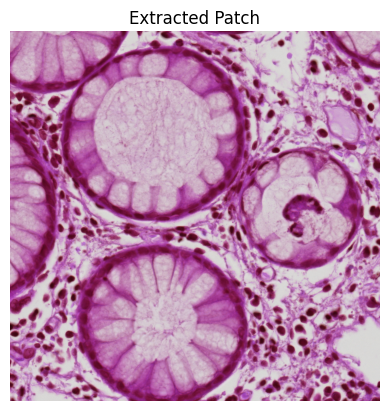

In [1]:
import os
import torch
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login 
from pylibCZIrw import czi
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import requests
def download_file(url, local_path):
    if not os.path.exists(local_path):
        print(f"Downloading {url} to {local_path}...")
        r = requests.get(url, stream=True)
        with open(local_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f"File already exists at {local_path}. Skipping download.")

# URL to the file
file_url = "https://www.ebi.ac.uk/biostudies/files/S-BIAD1285/SR1482_WSIs/SR1482_40X_HE_T232_01.czi"
# Local path where the file should be stored
local_path = "/data2/SR1482_40X_HE/SR1482_40X_HE_T232_01.czi"

# 1) Download if needed
download_file(file_url, local_path)

# 2) Open the CZI file, compute bounding box, read a patch
patch_size = 2048
with czi.open_czi(local_path) as czidoc:
    bbox = czidoc.total_bounding_box
    x_min, x_max = bbox['X']
    y_min, y_max = bbox['Y']

    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2

    roi_x = center_x - patch_size // 2
    roi_y = center_y - patch_size // 2

    # Read the patch at full resolution (zoom=1.0)
    patch = czidoc.read(roi=(roi_x, roi_y, patch_size, patch_size), zoom=1.0)

# patch is returned as a NumPy array, typically shape [Height, Width, Channels]
print("Patch shape:", patch.shape)

plt.imshow(patch)
plt.axis('off')
plt.title("Extracted Patch")
plt.show()


## Step 2: Login and initiaise the UNI embedding model.
This model can be easily swapped out.

In [2]:
# If you have a Hugging Face access token:
login()  # logs in using your HF token, necessary for private models or if you want to push/fetch quickly

model = timm.create_model(
    "hf-hub:MahmoodLab/uni",
    pretrained=True,
    init_values=1e-5,   # required for LayerScale parameters
    dynamic_img_size=True
)
# Create transform from model's pretrained config
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval();


## Step 3: Extract features from the patch

In [3]:
# Convert the extracted patch (NumPy array) to a PIL Image
patch_img = Image.fromarray(patch)

# Apply the transform from the timm data config (or your custom transforms)
input_tensor = transform(patch_img).unsqueeze(dim=0)  # shape: [1, 3, 224, 224]

# Extract features
with torch.no_grad():
    patch_embedding = model(input_tensor)  # shape: [1, 1024] for UNI (ViT-L/16)

print("Feature embedding shape:", patch_embedding.shape)


Feature embedding shape: torch.Size([1, 1024])


In [4]:
print(patch_embedding)

tensor([[-0.7149,  1.1233,  0.4601,  ..., -1.4894, -1.5121,  1.8039]])
